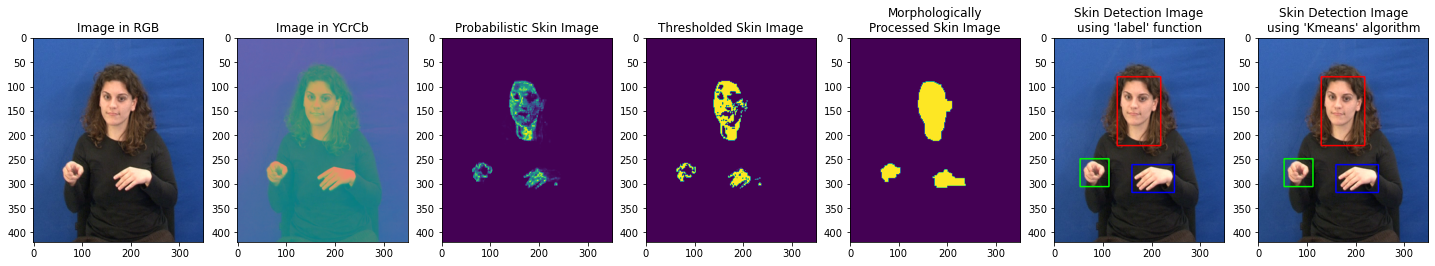

Output Characteristics using 'scipy.ndimage.label': --> Head: [129, 81, 89, 141]
						    --> Left Arm: [53, 249, 59, 57]
						    --> Right Arm: [159, 261, 87, 57]

Output Characteristics using 'sklearn.cluster.KMeans':  --> Head: [129, 81, 89, 141]
							--> Left Arm: [53, 249, 59, 57]
							--> Right Arm: [159, 261, 87, 57]


In [1]:
#####################################################################################################################
###################################################### PART 1 #######################################################
#####################################################################################################################
####################################################### 1.1.1 #######################################################
##################################################################################################################### 

#!/usr/bin/env python
import numpy as np
import scipy.io
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
from scipy import signal
from sklearn.cluster import KMeans
from scipy.ndimage import label, map_coordinates
from tqdm import tqdm

# make directory for outputs
if not os.path.isdir('outputs'):
    os.mkdir('outputs')

if not os.path.isdir('outputs/ex1'):
    os.mkdir('outputs/ex1')

mat = scipy.io.loadmat('data/skinSamplesRGB.mat') # read the "skinSamplesRGB.mat" file
skinRGB = mat['skinSamplesRGB'] # keep array of RGB colours
#print(skinRGB.shape) # =(22, 81, 3) we assume RED->[:,:,0], GREEN->[:,:,1], BLUE->[:,:,2]

#define Y-Cb-Cr from R-B-G
skinYCrCb = cv2.cvtColor(skinRGB, cv2.COLOR_RGB2YCrCb)
Y = skinYCrCb[:,:,0]
Cr = skinYCrCb[:,:,1]
Cb = skinYCrCb[:,:,2]
#print('Component Y =\n{}\n'.format(Y))
#print('Component Cb =\n{}\n'.format(Cb))
#print('Component Cr =\n{}\n'.format(Cr))

# flatten the arrays 
Cb_flat = Cb.reshape(1,-1)
Cr_flat = Cr.reshape(1,-1)

#define  mean nad covariance
mean = np.array([np.mean(Cr_flat),np.mean(Cb_flat)])
cov = np.cov(Cr_flat,Cb_flat)

# calculate P
P = scipy.stats.multivariate_normal(mean,cov)

# read image and convert in Y-Cr-Cb
path = 'data/1.png'
img_org = cv2.imread(path) # read image in BGR
plt.figure(figsize=(25,15))
plt.subplot(1,7,1)
plt.title("Image in RGB")
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)) # print image in RGB for check
plt.subplot(1,7,2)
plt.title("Image in YCrCb")
img_YCrCb = cv2.cvtColor(img_org, cv2.COLOR_BGR2YCrCb) # convert image in YCrCb
plt.imshow(img_YCrCb) # print image in YCrCb for check

Cr = img_YCrCb[:,:,1] #Cr component
Cb = img_YCrCb[:,:,2] #Cb component
Cr_flat = Cr.reshape(1,-1) #flattend Cr component
Cb_flat = Cb.reshape(1,-1) #flattend Cb component
c = np.dstack((Cr, Cb)) # create vector c

#limits for thresholding
limit = 0.25

# print the probabilistic image
plt.subplot(1,7,3)
plt.title("Probabilistic Skin Image")
plt.imshow(P.pdf(c)/np.max(P.pdf(c))) # print skin image 

# define skin for image
skin = ((P.pdf(c)/np.max(P.pdf(c)))>=limit)
skin = skin.astype(int)
coordy, coordx = np.where(skin==1)

img_skin = np.zeros((img_YCrCb.shape[0],img_YCrCb.shape[1]))

coords = np.stack((coordy,coordx),axis=-1)
for el in coords:
    i = el[0]
    j = el[1]
    img_skin[i,j] = 1

plt.subplot(1,7,4)
plt.title("Thresholded Skin Image")
plt.imshow(img_skin) # print skin image 

# Morphological opening and closing
kern_open = np.ones((2,2),dtype=np.uint8) # Create morphological kernel for opening
kern_close = np.ones((11,11),dtype=np.uint8) # Create morphological kernel for opening

img_skin = cv2.morphologyEx(cv2.morphologyEx(img_skin, cv2.MORPH_OPEN, kern_open), cv2.MORPH_CLOSE, kern_close, iterations=5) 
plt.subplot(1,7,5)
plt.title("Morphologically\nProcessed Skin Image")
plt.imshow(img_skin) # print morphologically changed skin image 


# Create 3 clusters for the two hand and the head using "scipy.ndimage.label"
labels, features = label(img_skin) # define the clusters
#print(features)
output_char_label = [] # the output list code : [{head},{left_hand},{right_hand}]
img_rec_label = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
color = [(255,0,0),(0,255,0),(0,0,255)] # define color of rectagulars

# Find the boundaries for the 3 clusters
offset = 10 # offset for bigger bounding boxes
for i in range(1,features+1):
    coordy, coordx = np.where(labels == i)
    coords = np.stack((coordy,coordx),axis=-1)
    top = coordy.min() - offset
    bottom = coordy.max() + offset
    left = coordx.min() - offset
    right = coordx.max() + offset
    output_char_label.append([left, top, right-left ,bottom-top]) # the outputs list
    img_rec_label = cv2.rectangle(img_rec_label, (left, top), (right, bottom), color[i-1], 2) # make image with rectagulars

plt.subplot(1,7,6)
plt.title("Skin Detection Image\nusing 'label' function")
plt.imshow(img_rec_label) 


# Create 3 clusters for the two hand and the head using "Kmeans"
pos = np.nonzero(img_skin) 
data = tuple(zip(pos[0],pos[1]))
data = np.asarray(data).reshape(-1,2) #create array witn nonzero pixels
kmeans = KMeans(3,n_init=25) # Perform KMeans algorithm diven from library 'sklearn'
kmeans.fit(data) 
num_labels = np.unique(kmeans.labels_)
clusters = [data[kmeans.labels_ == label] for label in num_labels] # create three seperated clusters

#sort the clusters in a unique way : [{head},{left_hand},{right_hand}]
clusters_sorted = []
clusters_sorted.append(clusters[(np.where(np.transpose(kmeans.cluster_centers_)[0]==min(np.transpose(kmeans.cluster_centers_)[0])))[0][0]])
clusters_sorted.append(clusters[(np.where(np.transpose(kmeans.cluster_centers_)[1]==min(np.transpose(kmeans.cluster_centers_)[1])))[0][0]])
clusters_sorted.append(clusters[(np.where(np.transpose(kmeans.cluster_centers_)[1]==max(np.transpose(kmeans.cluster_centers_)[1])))[0][0]])

output_char_kmeans = [] # the output list code : [{head},{left_hand},{right_hand}]
img_rec_kmeans = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
color = [(255,0,0),(0,255,0),(0,0,255)] # define color of rectagulars
i=0
offset = 10 # offset for bigger bounding boxes
for array in clusters_sorted:
    positions = np.transpose(array)
    top = positions[0].min() - offset
    bottom = positions[0].max() + offset
    left = positions[1].min() - offset
    right = positions[1].max() + offset
    output_char_kmeans.append([left, top, right-left ,bottom-top]) # the outputs list
    img_rec_kmeans = cv2.rectangle(img_rec_kmeans, (left, top), (right, bottom), color[i], 2) # make image with rectagulars
    i += 1
plt.subplot(1,7,7)
plt.title("Skin Detection Image\nusing 'Kmeans' algorithm")
plt.imshow(img_rec_kmeans) 
plt.show()

if (len(output_char_label) == 3):
    print("Output Characteristics using 'scipy.ndimage.label': --> Head: {}\n\t\t\t\t\t\t    --> Left Arm: {}\n\t\t\t\t\t\t    --> Right Arm: {}\n".format(output_char_label[0],output_char_label[1],output_char_label[2]))
else:
    print("Output Characteristics using 'scipy.ndimage.label': {}\n".format(output_char_label[0]))
print("Output Characteristics using 'sklearn.cluster.KMeans':  --> Head: {}\n\t\t\t\t\t\t\t--> Left Arm: {}\n\t\t\t\t\t\t\t--> Right Arm: {}".format(output_char_kmeans[0],output_char_kmeans[1],output_char_kmeans[2]))

In [2]:
# Function for the question 1.1
# Image must be given in BGR

def expand(i, top, bottom, left, right, same):
    
    # For task 1.1 we apply same offset to make it more clear #
    if same:
        top -= offset
        bottom += offset
        left -= offset
        right += offset

    # For all other tasks we apply different offset to track more efficiently #
    else:

        if i==1:
            bottom -= 25
            left -= 8
            right += 5
        if i==2:
            top -= 15
            bottom += 20
            left -= 30
            right += 5
        if i==3:
            top -= 10
            bottom += 10
            left -= 7
            right += 5
    
    return top, bottom, left, right

def BoundingBox(img,mean,cov,clusterization_method='label',thr_lim=0.25,morph_iter=5,kmeans_iter=25, same=True):
    
    # calculate P #
    P = scipy.stats.multivariate_normal(mean,cov) # calculate P
    
    # convert image in YCrCb #
    img_YCrCb = cv2.cvtColor(img_org, cv2.COLOR_BGR2YCrCb) 
   
    #Cr-Cb components #
    Cr = img_YCrCb[:,:,1] 
    Cb = img_YCrCb[:,:,2]
    
    #flattend Cr-Cb components #
    Cr_flat = Cr.reshape(1,-1) 
    Cb_flat = Cb.reshape(1,-1)
    
    # create vector c #
    c = np.dstack((Cr, Cb))
    
    # define skin for image #
    skin = ((P.pdf(c)/np.max(P.pdf(c)))>=thr_lim)
    skin = skin.astype(int)
    coordy, coordx = np.where(skin==1)
    img_skin = np.zeros((img_YCrCb.shape[0],img_YCrCb.shape[1]))
    coords = np.stack((coordy,coordx),axis=-1)
    for el in coords:
        i = el[0]
        j = el[1]
        img_skin[i,j] = 1
        
    # Create morphological kernel for opening #
    kern_open = np.ones((2,2),dtype=np.uint8)
    
    # Create morphological kernel for closing #
    kern_close = np.ones((11,11),dtype=np.uint8) 
    
    # Morphological opening and closing #
    img_skin = cv2.morphologyEx(cv2.morphologyEx(img_skin, cv2.MORPH_OPEN, kern_open), cv2.MORPH_CLOSE, kern_close, iterations=morph_iter) 

    # the output list code : [{head},{left_hand},{right_hand}]
    output_char = [] 
    
    # BGR2RGB Transformation #
    img_rec = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # define color of rectagulars #
    color = [(255,0,0),(0,255,0),(0,0,255)] 
    
    # Define offset #
    offset = 10
    
    if (clusterization_method == 'label'):
        # Create 3 clusters for the two hand and the head using "scipy.ndimage.label"
        labels, features = label(img_skin) # define the clusters
        
        # Find the boundaries for the 3 clusters #
        for i in range(1,features+1):

            coordy, coordx = np.where(labels == i)
            coords = np.stack((coordy,coordx),axis=-1)
            top = coordy.min() 
            bottom = coordy.max()  
            left = coordx.min() 
            right = coordx.max()  
            
            # Expand the boundaries #
            top, bottom, left, right = expand(i, top, bottom, left, right, same)

            # the outputs list #
            output_char.append([left, top, right-left ,bottom-top]) 

            # draw rects onto the image #
            img_rec = cv2.rectangle(img_rec, (left, top), (right, bottom), color[i-1], 2) 

    else:
        
        # Create 3 clusters for the two hand and the head using "Kmeans"
        pos = np.nonzero(img_skin) 
        data = tuple(zip(pos[0],pos[1]))
        data = np.asarray(data).reshape(-1,2) #create array witn nonzero pixels
        kmeans = KMeans(3,n_init=25) # Perform KMeans algorithm diven from library 'sklearn'
        kmeans.fit(data) 
        num_labels = np.unique(kmeans.labels_)
        clusters = [data[kmeans.labels_ == label] for label in num_labels] # create three seperated clusters
        
        #sort the clusters in a unique way : [{head},{left_hand},{right_hand}]
        clusters_sorted = []
        clusters_sorted.append(clusters[(np.where(np.transpose(kmeans.cluster_centers_)[0]==min(np.transpose(kmeans.cluster_centers_)[0])))[0][0]])
        clusters_sorted.append(clusters[(np.where(np.transpose(kmeans.cluster_centers_)[1]==min(np.transpose(kmeans.cluster_centers_)[1])))[0][0]])
        clusters_sorted.append(clusters[(np.where(np.transpose(kmeans.cluster_centers_)[1]==max(np.transpose(kmeans.cluster_centers_)[1])))[0][0]])
        
        i=0
        for array in clusters_sorted:
            
            positions = np.transpose(array)
            top = positions[0].min() 
            bottom = positions[0].max() 
            left = positions[1].min()
            right = positions[1].max() 
            
            # Expand the boundaries #
            top, bottom, left, right = expand(i, top, bottom, left, right, same)

            # the outputs list #
            output_char.append([left, top, right-left ,bottom-top]) 

            # draw rects onto the image #
            img_rec = cv2.rectangle(img_rec, (left, top), (right, bottom), color[i-1], 2) 

            i += 1
        
    return img_rec,output_char

In [3]:
#Testing the function 

mat = scipy.io.loadmat('data/skinSamplesRGB.mat') # read the "skinSamplesRGB.mat" file
skinRGB = mat['skinSamplesRGB'] # keep array of RGB colours

#define Y-Cb-Cr from R-B-G
skinYCrCb = cv2.cvtColor(skinRGB, cv2.COLOR_RGB2YCrCb)
Y = skinYCrCb[:,:,0]
Cr = skinYCrCb[:,:,1]
Cb = skinYCrCb[:,:,2]

# flatten the arrays 
Cb_flat = Cb.reshape(1,-1)
Cr_flat = Cr.reshape(1,-1)

# define  mean nad covariance
mean = np.array([np.mean(Cr_flat),np.mean(Cb_flat)])
cov = np.cov(Cr_flat,Cb_flat)

# read image
path = 'data/1.png'
img= cv2.imread(path) # read image in BGR

_,out = BoundingBox(img,mean,cov)
print('Output Characteristics: --> Head: {}\n\t\t\t--> Left Arm: {}\n\t\t\t--> Right Arm: {}'.format(out[0],out[1],out[2]))

Output Characteristics: --> Head: [129, 81, 89, 141]
			--> Left Arm: [53, 249, 59, 57]
			--> Right Arm: [159, 261, 87, 57]


In [4]:
#####################################################################################################################
####################################################### 1.2.1 #######################################################
##################################################################################################################### 
import time
def limits(coord, neighbor, limit):
    
    if (coord-neighbor//2 < 0) and coord + neighbor//2 > limit:
        coord_max = limit
        coord_min = 0
        fcoord = coord
        
    elif coord + neighbor//2 > limit:
        coord_max = limit
        coord_min = coord_max-neighbor+1
        fcoord = coord - coord_min
        
    elif (coord-neighbor//2 < 0):
        coord_min = 0
        coord_max = neighbor
        fcoord = coord #coord_min == 0
        
    else:
        coord_min = coord - neighbor//2
        coord_max = coord + neighbor//2
        fcoord = coord - coord_min
        
    return coord_min, coord_max, fcoord

def Gaussian_2D(sigma):
    n = int(2*np.ceil(3*sigma)+1)
    gauss1D = cv2.getGaussianKernel(n, sigma) # Column vector
    gauss2D = gauss1D @ gauss1D.T # Symmetric gaussian kernel
    return gauss2D # Return the Gaussian_2D filter


def lk(I1, I2, features, rho, epsilon, dx0, dy0):
    
    # Define neighbor #
    neighbor = int(2*np.ceil(3*rho)+1)
    
    # Normalization #
    I1 = (I1 - I1.min())/I1.max()
    I2 = (I2 - I2.min())/I2.max()
    
    # Define Gaussian #
    gauss = Gaussian_2D(rho)
    
    # Find Gradient #
    gy, gx = np.gradient(I1)
    
    # Define Optical Flow list of Vectors #
    d = []
    
    for feature in features:
        
        # Define feature coordinates #
        f = (feature[1], feature[0])
        
        # Define Control Input #
        u = np.zeros(2)
        
        # Cut the Images around the Corners #
        y_top, y_bottom, fy = limits(f[0], neighbor, I1.shape[0])
        x_left, x_right, fx = limits(f[1], neighbor, I1.shape[1])

        I1_crop = I1[y_top:y_bottom, x_left:x_right]
        I2_crop = I2[y_top:y_bottom, x_left:x_right]
        
        # Cut gradients #
        gy_crop = gy[y_top:y_bottom, x_left:x_right]
        gx_crop = gx[y_top:y_bottom, x_left:x_right]
        
        # Define new feature coordinates #
        f_sh = (fy, fx)
        
        # Define Dimensions #
        dimy = I1_crop.shape[0]
        dimx = I1_crop.shape[1]

        # Define Functions Domain #
        x = np.linspace(0, dimx-1, dimx)
        y = np.linspace(0, dimy-1, dimy)

        # Define Coordinates of Functions #
        xx, yy = np.meshgrid(x, y)

        # Initialize Optical Flow Vectors: di-1, di #
        prev_d = np.zeros(2)
        current_d = np.array([dx0, dy0], dtype='float')   

        # Initialize norm #
        norm = np.inf

        # Initialize iterations #
        iterations = 0
        start_time = time.time()
        while(norm > 0.005):


            # Define Coordinates of Optical Flow #
            dx, dy = current_d

            # Define A matrix with Shifted Gradients #
            A1 = map_coordinates(gx_crop, [np.ravel(yy+dy), np.ravel(xx+dx)], order=1).reshape(dimy, dimx)
            A2 = map_coordinates(gy_crop, [np.ravel(yy+dy), np.ravel(xx+dx)], order=1).reshape(dimy, dimx)

            # Define matrices for Computing Control Input 'u' #
            Ga11 = cv2.filter2D(A1**2, -1, gauss) + epsilon
            Ga22 = cv2.filter2D(A2**2, -1, gauss) + epsilon
            Ga12 = cv2.filter2D(A1*A2, -1, gauss)
            Ga21 = Ga12

            # Shift Previous Frame to match with Next #
            I1_shifted = map_coordinates(I1_crop, [np.ravel(yy+dy), np.ravel(xx+dx)], order=1).reshape(dimy, dimx)

            # Define E (error) #
            E = I2_crop - I1_shifted

            # Convolve Error with Gaussian #
            Ge1 = cv2.filter2D(A1*E, -1, gauss)
            Ge2 = cv2.filter2D(A2*E, -1, gauss)

            # Find the Values of Functions Gas #
            ga11 = map_coordinates(Ga11, [[f_sh[0]], [f_sh[1]]], order=1)[0]
            ga22 = map_coordinates(Ga22, [[f_sh[0]], [f_sh[1]]], order=1)[0]
            ga12 = map_coordinates(Ga12, [[f_sh[0]], [f_sh[1]]], order=1)[0]
            ga21 = ga12

            # Find the Values of Functions Ges #
            ge1 = map_coordinates(Ge1, [[f_sh[0]], [f_sh[1]]], order=1)[0]
            ge2 = map_coordinates(Ge2, [[f_sh[0]], [f_sh[1]]], order=1)[0]

            # Define Ga-matrix and Ge vector #
            Ga = np.array([[ga11, ga12],
                           [ga21, ga22]])

            Ge = np.array([[ge1],
                          [ge2]])

            # Update Control Input #    
            u = np.ravel(np.linalg.inv(Ga)@Ge)
                
            # Update Closed Loop and Proceed to Next Iteration #
            prev_d = np.copy(current_d)
            current_d += u

            # Update Norm #
            norm = np.linalg.norm(current_d-prev_d)

            # Increase Iterations #
            iterations += 1
            if iterations == 500:
                break
        
        # Add the vector to the list #
        d.append(current_d[:])
        
#         print(f'I made it!! I reduced norm to {norm}, after {iterations} iterations!')
    # Caclucate time of Convergence #
    end_time = time.time()
    convergence_time=end_time-start_time
    
    # Transform d to array #
    d = np.array(d)
    
    # Optical Flow from frame-1 to frame-2 #
    d = -d
    
    return d, iterations, convergence_time
        



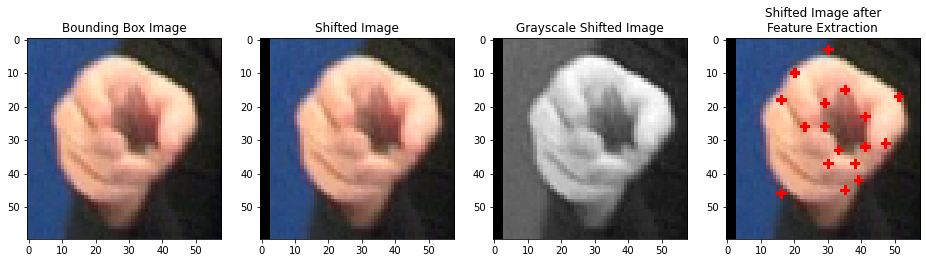

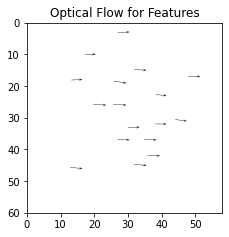

The estimated shifting factor for each feature is: feature #1 : [2.93887772 0.02526024]
						   feature #2 : [ 3.06520018 -0.12728069]
						   feature #3 : [2.80119952 0.28958249]
						   feature #4 : [ 2.83316456 -0.13119154]
						   feature #5 : [ 3.14090879 -0.02611063]
						   feature #6 : [3.34438079 0.16631257]
						   feature #7 : [3.26974687 0.19623364]
						   feature #8 : [2.95863198 0.42173657]
						   feature #9 : [3.07859994 0.03458746]
						   feature #10 : [3.28813012 0.55527153]
						   feature #11 : [3.21535055 0.02488754]
						   feature #12 : [3.15170008 0.16913709]
						   feature #13 : [3.1422861  0.33388395]
						   feature #14 : [ 3.03007139 -0.1392702 ]
						   feature #15 : [ 2.730329   -0.02651952]
						   feature #16 : [3.30345064 0.17388487]
						   feature #17 : [3.27156725 0.27615462]


In [5]:
#Testing the function 

img_og = cv2.imread('data/1.png') # read image in BGR
_,[face,l_hand,r_hand] = BoundingBox(img_og,mean,cov) # call BoundingBox function

# define specs of left hand | we will use this for opticalization
x = l_hand[0]
y = l_hand[1]
height = l_hand[2]
width = l_hand[3]

img = img_og[y:y+height+1,x:x+width+1] #define image of left hand
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image of left hand in RGB
plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.title("Bounding Box Image")
plt.imshow(img_RGB) # print image for check

img_shift = scipy.ndimage.shift(img, np.array([0,3,0]))
img_shift_RGB = cv2.cvtColor(img_shift, cv2.COLOR_BGR2RGB)
plt.subplot(1,4,2)
plt.title("Shifted Image")
plt.imshow(img_shift_RGB)

gray_img_shift = cv2.cvtColor(img_shift,cv2.COLOR_RGB2GRAY) #make image in grayscale to be used in goodFeaturesToTrack
plt.subplot(1,4,3)
plt.title("Grayscale Shifted Image")
plt.imshow(gray_img_shift, cmap='gray') # print image for check

# features extraction for given image
features = cv2.goodFeaturesToTrack(gray_img_shift,17,0.01,5) # (preferred value=0.01) from https://www.geeksforgeeks.org/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/
features = np.squeeze(np.int0(features))

img_draw = np.copy(img_shift_RGB) # copy to draw the circles
for i in features:
    x,y = i.ravel()
    cv2.circle(img_draw,(x,y),1,255,-1)
plt.subplot(1,4,4)
plt.title("Shifted Image after\nFeature Extraction")
plt.imshow(img_draw)
plt.show()

# make images in grayscale 
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_shift = cv2.cvtColor(img_shift,cv2.COLOR_BGR2GRAY)
                    
# Define Parameters and Call Lukas-Kanade
rho = 4
epsilon = 0.01
dx0, dy0 = 0,0
shift, _, _ = lk(img,img_shift,features,rho,epsilon,dx0,dy0)

# optical flow
head_params = dict(headwidth=7,headaxislength=5,headlength=10,width=0.002) 

# Shift the features to match with image1 #
feat1 = features - shift

plt.figure(figsize=(3.5,3.5))
plt.title("Optical Flow for Features")       
plt.quiver(feat1[:,0],feat1[:,1],shift[:,0],shift[:,1],angles='xy',scale=50,**head_params)
plt.xlim(0,img.shape[1])
plt.ylim(img.shape[0],0)
plt.show()

#results
for i in range (len(features)):
    if i==0:
        print('The estimated shifting factor for each feature is:','feature #{} : {}'.format(i+1, shift[i]))
    else:
        print('\t\t\t\t\t\t   feature #{} : {}'.format(i+1, shift[i]))

In [6]:
#####################################################################################################################
####################################################### 1.2.2 #######################################################
##################################################################################################################### 

# Create directory to save the frames and optical_flow from LK
if not os.path.isdir('outputs/ex1/LKframes'):
    os.mkdir('outputs/ex1/LKframes')

if not os.path.isdir('outputs/ex1/LKopticalflow'):
    os.mkdir('outputs/ex1/LKopticalflow')

# Create directory to save the frames and optical_flow from Multi_LK
if not os.path.isdir('outputs/ex1/Multi_LKframes'):
    os.mkdir('outputs/ex1/Multi_LKframes')

if not os.path.isdir('outputs/ex1/Multi_LKopticalflow'):
    os.mkdir('outputs/ex1/Multi_LKopticalflow')
    

def displ(dxs, dys, multi=False):    
    
    if multi:
        thres = 0.001
    else:
        thres = 0.1 #0.1
        
    # Vector List with Energy higher than threshold #
    opt_vect = []

    for dx, dy in zip(dxs, dys):
        
        # Find Energy #
        E = dx**2 + dy**2

        if E <= thres:
            continue
        
        # Add new vector #
        opt_vect.append(np.array([dx, dy]))
    
    # Transform to array #
    opt_vect = np.array(opt_vect)
    
    try:
        # Define Vectors #
        dxs = opt_vect[:, 0]
        dys = opt_vect[:, 1]

        # Find means #
        mx = np.mean(dxs)
        my = np.mean(dys)

        # Find mean vector and covariance matrix #
        m = np.array([mx, my])
        Cov = np.cov(dxs, dys)

        # Create Gaussian Distribution #
        p = scipy.stats.multivariate_normal(m,Cov) 
        coords = list(zip(dxs, dys))

        # Get probs #
        probs = p.pdf(coords)

        # Normalization #
        weights = (probs-probs.min())/probs.max()

        # Compute weighted average insted of mean #
        return np.average(opt_vect, weights=weights, axis=0)
    
    except Exception:
        
        # Compute mean #
        return np.mean(opt_vect, axis=0)


def performLukasKanade(path, mean, cov, rho, epsilon, dx0, dy0, scales=None, multi=False, create_graphs=False):
    
    # Define counter of loops and time, algorithm needs to converge #
    ITERATIONS = 0
    TIME = 0
    
    # Load all frames' names #
    frames = ['{}.png'.format(i+1) for i in range (len([name for name in os.listdir(path)])-1)] 
    
    # Roll frames' names #
    frames_roll = np.roll(frames, -1) 
    
    # parameters for optical flow #
    head_params = dict(headwidth=7,headaxislength=5,headlength=10,width=0.002) 
 
    # array to append results from LK #
    d_out = [] 

    for indx, (img1, img2) in enumerate(tqdm(zip(frames, frames_roll), total=len(frames)-1, desc="Processing...")):
        if indx == 65: # break in the last iteration
            break
            
        img1 = cv2.imread(path+'/'+img1) # Load Image 1 
        img2 = cv2.imread(path+'/'+img2) # Load Image 2 

        if indx == 0:
            # Find Boxes for the 1st frame #
            img_bount_1,skin_chars = BoundingBox(img1, mean, cov, same=False) 
            
            if multi:
                matplotlib.image.imsave('outputs/ex1/Multi_LKframes/frame1.png', img_bount_1)
            else:
                matplotlib.image.imsave('outputs/ex1/LKframes/frame1.png', img_bount_1)

        # Make them gray and rename to frame@ #
        frame1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        frame2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # BGR2RGB Transformation 

        i = 0 # Indexing
        sub_title = ['Head','Left Arm', 'Right Arm']
        
        d_frame = [] # list to append (dx,dy) for each Bounding Box of each frame
        
        if (create_graphs==True):
            plt.figure(figsize=(15,8))

        for char in skin_chars:

            # Find boundaries #
            x = char[0]
            y = char[1]
            width = char[2]
            height = char[3]

            # Cut images
            frame1_cut = frame1[y:y+height, x:x+width]
            frame2_cut = frame2[y:y+height, x:x+width]

            # Extract Features #
            features = cv2.goodFeaturesToTrack(frame2_cut, 20, 0.05, 5)
            features = np.squeeze(features.astype(int))
            
            if multi==True:
                # Call multi_lk-function #
                dflx, dfly, d , iterations, cov_time = multi_lk(frame1_cut, frame2_cut, features, scales, rho, epsilon, dx0, dy0)
            else:
                # Call lk-function #
                d, iterations, cov_time = lk(frame1_cut, frame2_cut, features, rho, epsilon, dx0, dy0)
                
                # Call displ-function #
                dflx, dfly = displ(d[:, 0], d[:, 1])
            
            # Add time and total loops#
            ITERATIONS += iterations
            TIME += cov_time
                
            # Make them pixels #
            new_left = int(np.round(x+dflx))
            new_top = int(np.round(y+dfly))

            # Update Boundaries #
            new_right = int(np.round((x+dflx) + width ))
            new_bottom = int(np.round((y+dfly) + height))
            
            # Draw Rects #
            img2 = cv2.rectangle(img2, (new_left, new_top), (new_right, new_bottom), color[i], 2) 
            
            
            # Update Coordinates #
            char[0] = new_left
            char[1] = new_top
            
            d_frame.append(np.array([dflx, dfly])) # append (l2_norm{dx},l2_norm{dy}) for each bounding box
            
            # Creation of optical flow images
            feat1 = features - d # Shift the features to match with previous image
            
            if (create_graphs==True):
                plt.subplot(1,3,i+1)
                plt.title('{} for\nframes: {} -> {}'.format(sub_title[i],indx+1,indx+2))
                plt.quiver(feat1[:,0],feat1[:,1],d[:,0],d[:,1],angles='xy',scale=50,**head_params)
                plt.xlim(0,frame1_cut.shape[1])
                plt.ylim(frame1_cut.shape[0],0)
        
            i += 1
        if (create_graphs==True): 
            if multi:
                plt.savefig('outputs/ex1/Multi_LKopticalflow/frame{}.png'.format(indx+1))
            else:
                plt.savefig('outputs/ex1/LKopticalflow/frame{}.png'.format(indx+1))
            plt.close()
        
        d_out.append(np.array(d_frame)) # append d_frame for each frame
        
        if (create_graphs==True):
            if multi:
                 # Save the plotted image
                matplotlib.image.imsave('outputs/ex1/Multi_LKframes/frame{}.png'.format(indx+2), img2)
            else:
                matplotlib.image.imsave('outputs/ex1/LKframes/frame{}.png'.format(indx+2), img2)
        plt.close()
    return np.array(d_out), ITERATIONS/65, TIME/65 # an array:(num_frames-1,3,2) with the last dimention cointind d=(dx,dy) for each frame


# Function that creates a video from given directory with frames | original code from https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
def CreateVideo(image_folder,video_name,fps=25):
    num_frames = len([name for name in os.listdir(image_folder)]) # calculate number of frames
    images = ['frame{}.png'.format(i+1) for i in range(num_frames)] # list with frames' name
    frame = cv2.imread(os.path.join(image_folder, images[0])) 
    height, width, layers = frame.shape # characteristics of dimensions for video
    video = cv2.VideoWriter(video_name, 0, fps, (width,height)) # video creator
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image))) # create video
    cv2.destroyAllWindows()
    video.release()

In [8]:
# test function and create videos
path = 'data'
# Define Parameters #
rho = 4
epsilon = 0.01
dx0, dy0 = 0,0

d_LK, iterations, cov_time = performLukasKanade(path, mean, cov, rho, epsilon, dx0, dy0,create_graphs=True)
print(iterations, cov_time)
# CreateVideo('outputs/ex1/LKframes','outputs/ex1/LKframes.avi')
# CreateVideo('outputs/ex1/LKopticalflow','outputs/ex1/LKopticalflow.avi',fps=10)

Processing...:  98%|█████████▊| 65/66 [02:21<00:02,  2.18s/it]

208.63076923076923 0.13049479264479416


In [ ]:
# test function and create videos
path = 'data'
dx0, dy0 = 0,0

rhos = [3,4,5]
epsilons = [0.03,0.06,0.1]

rhos_ITERATIONS = {}
rhos_COVERGENCE = {}
eps_ITERATIONS = {}
eps_COVERGENCE = {}

for j in rhos:
    rhos_ITERATIONS[j] = []
    rhos_COVERGENCE[j] = []

for j in epsilons:
    eps_ITERATIONS[j] = []
    eps_COVERGENCE[j] = []

    
# We try our algorithm for various values of (ρ,ε) #
for i in rhos:
    iterations = []
    covergence = []
    for j in epsilons:
        d_LK, iteration, cov_time = performLukasKanade(path, mean, cov, i, j, dx0, dy0,create_graphs=False)
        eps_ITERATIONS[j].append(iteration)
        eps_COVERGENCE[j].append(cov_time)
        rhos_ITERATIONS[i].append(iteration)
        rhos_COVERGENCE[i].append(cov_time)   
    

In [ ]:
# Make statistics for various combinations of (ρ,ε) #

import pandas
import seaborn as sns

columns_labels = ['3','4','5']
row_labels  = ['0.03','0.06','0.1']
values = []
for i in rhos:
    values.append(list(zip(rhos_ITERATIONS[i],rhos_COVERGENCE[i])))
print(values)

cm = sns.light_palette("pink", as_cmap=True)

df1 = pandas.DataFrame(values, columns=columns_labels, index=row_labels)
pandas.options.display.float_format = "{:.3f}".format


df1.style.set_caption("epsilon/rho")\
    .background_gradient(cmap=cm)


In [ ]:
# Make plots for various combinations of (ρ,ε) #

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,20))

for i in range(3):

    ax[0][i].plot(epsilons, rhos_ITERATIONS[rhos[i]], label = 'Average Iterations')
    ax[0][i].set_title(f'ρ = {rhos[i]}, ε ∈ {0.03,0.06,0.1}')
    ax[0][i].set_ylabel('Number of Iterations')
    ax[0][i].set_xlabel('epsilons')
    ax[0][i].legend()
    ax[1][i].plot(epsilons, rhos_COVERGENCE[rhos[i]], label = 'Average Convergence Time')
    ax[1][i].set_title(f'ρ = {rhos[i]}, ε ∈ {0.03,0.06,0.1}')
    ax[1][i].set_ylabel('Time(sec)')
    ax[1][i].set_xlabel('epsilons')
    ax[1][i].legend()
    ax[2][i].plot(rhos, eps_ITERATIONS[epsilons[i]], label = 'Average Iterations')
    ax[2][i].set_title(f'ε = {epsilons[i]}, ρ ∈ {3,4,5}')
    ax[2][i].set_ylabel('Number of Iterations')
    ax[2][i].set_xlabel('rhos')
    ax[2][i].legend()
    ax[3][i].plot(rhos, eps_COVERGENCE[epsilons[i]], label = 'Average Convergence Time')
    ax[3][i].set_title(f'ε = {epsilons[i]}, ρ ∈ {3,4,5}')
    ax[3][i].set_ylabel('Time(sec)')
    ax[3][i].set_xlabel('rhos')
    ax[3][i].legend()

In [9]:
#####################################################################################################################
####################################################### 1.2.3 #######################################################
##################################################################################################################### 
def multi_lk(frame1, frame2, features, scales, rho, epsilon, dx0, dy0):
    
    # Define Iteratrion and Time of Convergence #
    ITERATIONS = 0
    CONVERGENCE = 0
    
    # Define Gaussian Pyramids #
    pyramid1 = []
    pyramid2 = []
    
    # List for features #
    feats = []
    
    # Add original features #
    feats.append(np.copy(features))
    
    # Add first layers #
    pyramid1.append(frame1.copy())
    pyramid2.append(frame2.copy())

    for i in range(scales):
        
        # Downsample the Images #
        frame1 = cv2.pyrDown(frame1)
        frame2 = cv2.pyrDown(frame2)
        
        # Downsample the features #
        features = features//2       
        
        # Add downsampled features #
        feats.append(np.copy(features))
        
        # Add layers #
        pyramid1.append(frame1.copy())
        pyramid2.append(frame2.copy())

    for i in range(scales, -1, -1):
        
        # Define rho #
        ro = rho/(2**i)
        
        img1 = pyramid1[i]
        img2 = pyramid2[i]
        
        # Extract Features #
        feat = feats[i]

        # Call lk-function #
        d,iterations,cov_time = lk(img1, img2, feat, ro, epsilon, dx0, dy0)

        if i == 0:
            # Add time and iters #
            ITERATIONS += iterations
            CONVERGENCE += cov_time
        
        # Call displ-function #
        dflx, dfly = displ(d[:, 0], d[:, 1], multi=True)
#         print(dflx, dfly)
        
        dx0, dy0 = -2*dflx, -2*dfly 
        
    return dflx, dfly, d, ITERATIONS, CONVERGENCE

In [ ]:
# test function and create videos
path = 'data'
# Define Parameters #
rho = 4
epsilon = 0.01
dx0, dy0 = 0,0
scales = 3 #scales+1
multi = True
d_LK,iterations,cov_time = performLukasKanade(path, mean, cov, rho, epsilon, dx0, dy0, scales=scales, multi=multi,create_graphs=True)
print(iterations,cov_time)
# CreateVideo('outputs/ex1/Multi_LKframes','outputs/ex1/Multi_LKframes.avi')
# CreateVideo('outputs/ex1/Multi_LKopticalflow','outputs/ex1/Multi_LKopticalflow.avi',fps=10)

Processing...:  33%|███▎      | 22/66 [01:03<02:48,  3.84s/it]